In [122]:
%matplotlib widget
%matplotlib widget
import os
from pathlib import Path
import time
import torch
import numpy as np
import math
import gc
from functools import partial
from dataset import Dataset, load_dataframes_from_folder, reverse_normalization
from torch.utils.data import DataLoader
from transformer_zerostep import GPTConfig, GPT, warmup_cosine_lr
import argparse
import warnings
import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [123]:
# Overall settings
out_dir = "out"
batch_size = 1024

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
print(torch.cuda.is_available())

True


In [124]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_zerostep_sim_matlab_50pct_real_val_alt_h10_lr0_1_half_param.pt", map_location=device, weights_only=False)
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx
exp_data["iter_num"]
print(seq_len)
print(exp_data["iter_num"])
print(exp_data['best_val_loss'])

10
4385
0.0020668341749114916


In [125]:
# Expected rmse speed
np.sqrt(exp_data['best_val_loss']) * 2500

113.65611991088214

In [126]:
# # Remove `module.` prefix from keys
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in exp_data["model"].items():
#     name = k[7:] if k.startswith("module.") else k  # Remove `module.` prefix
#     new_state_dict[name] = v

In [127]:
exp_data.keys()

dict_keys(['model', 'optimizer', 'model_args', 'iter_num', 'train_time', 'LOSS', 'LOSS_VAL', 'best_val_loss', 'cfg'])

number of parameters: 0.00M


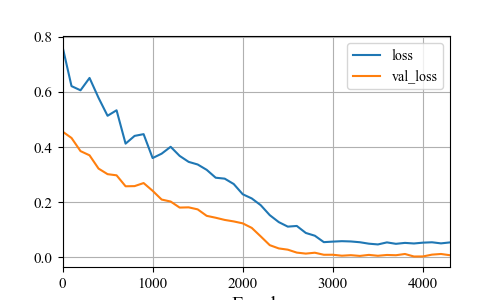

Model size in KB: 12.78515625


In [128]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    if k.startswith('module.'):
        state_dict[k[7:]] = v
        state_dict.pop(k)

model.load_state_dict(state_dict)

plt.figure(figsize=(5,3))
plt.plot(np.arange(exp_data['iter_num'])[::100], exp_data['LOSS'][::100], label="loss")
plt.plot(np.arange(exp_data['iter_num'])[::100], exp_data['LOSS_VAL'][::100], label="val_loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

size_in_bytes = sum(param.numel() * param.element_size() for param in model.parameters())
size_in_bytes += sum(buffer.numel() * buffer.element_size() for buffer in model.buffers())

# Convert bytes to kilobytes
size_in_kb = size_in_bytes / 1024
print('Model size in KB:', size_in_kb)

In [129]:
# folder_path = '../data/CL_experiments/test/inertia07_ki-0.0061-kp-11.8427'
folder_path = '../data/CL_experiments/test/inertia04_ki-0.0061-kp-11.8427'
# folder_path = '../data/simulated/10_percent'
# folder_path = '../data/simulated/50_percent_longer_steps'
# folder_path = '../data/CL_experiments/train/inertia13_ki-0.0061-kp-11.8427'


dfs = load_dataframes_from_folder(folder_path)
# Log the number of DataFrames loaded
print(f"Loaded {len(dfs)} DataFrames from {folder_path}.") 

# Create an instance of the dataset
dataset = Dataset(dfs=dfs, seq_len=1000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# df_idx = np.random.choice(len(dfs))
# df = dfs[df_idx]
# diff_array = df['r'].diff(-seq_len).to_numpy()
# diff_array = diff_array[~np.isnan(diff_array)]
# prob_ratio = 0.5 # ratio between constant samples and step samples
# if np.random.rand() >= prob_ratio:
#     good_idx = np.flatnonzero(diff_array == 0)
#     if len(good_idx) == 0:
#         good_idx = np.flatnonzero(diff_array != 0)
# else:
#     good_idx = np.flatnonzero(diff_array != 0)
#     if len(good_idx) == 0:
#         good_idx = np.flatnonzero(diff_array == 0)
# start_idx = np.random.choice(good_idx)
# batch_y = torch.tensor(df['omega'].iloc[start_idx:start_idx + seq_len].values, dtype=torch.float32)
# print(batch_y)


# Example of accessing an item
batch_u, batch_y = next(iter(dataloader))
batch_u, batch_y = batch_u.to(device), batch_y.to(device)
batch_y_pred = torch.empty_like(batch_y)
cputime = np.empty(batch_y.shape[1])

b, tt, _ = batch_y.shape 

Loaded 100 DataFrames from ../data/CL_experiments/test/inertia04_ki-0.0061-kp-11.8427.


In [130]:
cputime

array([             nan,              nan, -1.07213648e-154,
                    nan,  0.00000000e+000,  7.70446227e-312,
        7.70446227e-312,  7.70446227e-312,  7.70446226e-312,
        7.70446226e-312,  7.70446227e-312,  7.70446226e-312,
        7.70446227e-312,  7.70446226e-312,  7.70446226e-312,
        0.00000000e+000,  7.70993336e-312,  1.47762371e+248,
        7.70446100e-312,  7.70446100e-312,  6.22976328e+174,
        7.70446100e-312,  7.70446100e-312,  3.05686760e-057,
        7.70446100e-312,  7.70446100e-312,  7.70446100e-312,
        7.70446100e-312,  2.00253756e-052,  7.70446100e-312,
        9.08366791e+223,  6.14415221e-144,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,

In [131]:
H = exp_data["cfg"].seq_len

with torch.no_grad():
    
    for i in range(tt):
        
        print('time instant:', i)

        # Controller u(t) = C(e(t),u(t-1))
        start = time.time()
        if i < H:
            pred = model(batch_u[:, :i+1, :])
        else:
            pred = model(batch_u[:, i-H+1:i+1, :])
        
        cputime[i] = time.time() - start
        batch_y_pred[:,i,0] = pred[:,-1,0]
        print(cputime[i])

print(np.mean(cputime))
        
# Reverse norm
batch_u, batch_y, batch_y_pred = reverse_normalization(batch_u, batch_y, batch_y_pred)

time instant: 0
0.0019922256469726562
time instant: 1
0.0015268325805664062
time instant: 2
0.0020072460174560547
time instant: 3
0.0009963512420654297
time instant: 4
0.002259969711303711
time instant: 5
0.001987457275390625
time instant: 6
0.0010104179382324219
time instant: 7
0.0015287399291992188
time instant: 8
0.0020339488983154297
time instant: 9
0.0009920597076416016
time instant: 10
0.0013480186462402344
time instant: 11
0.0009911060333251953
time instant: 12
0.003142833709716797
time instant: 13
0.002514362335205078
time instant: 14
0.001020193099975586
time instant: 15
0.0024471282958984375
time instant: 16
0.002001047134399414
time instant: 17
0.0009949207305908203
time instant: 18
0.002025604248046875
time instant: 19
0.0015180110931396484
time instant: 20
0.002023935317993164
time instant: 21
0.001407623291015625
time instant: 22
0.002056121826171875
time instant: 23
0.0019583702087402344
time instant: 24
0.001447916030883789
time instant: 25
0.001522064208984375
time ins

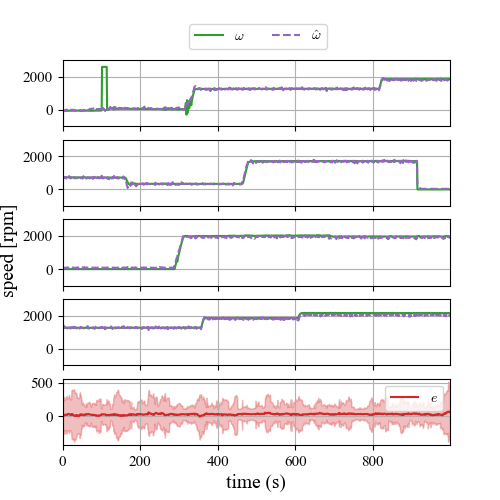

In [132]:
# Convert batch tensors to numpy for plotting
batch_y_np = batch_y.cpu().numpy()  # Shape (seq_len, 1)
batch_y_pred_np = batch_y_pred.cpu().numpy()  # Shape (seq_len, 1)

# Plotting
fig, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

# Plotting in each subplot
for i in range(4):
    axes[i].plot(batch_y_np[i], label=r"$\omega$", color="tab:green")
    axes[i].plot(batch_y_pred_np[i], label=r"$\hat{\omega}$", color="tab:purple", linestyle="--")
    axes[i].set_ylim([-1000, 3000])
axes[0].legend(bbox_to_anchor=(0.7, 1.65), ncols=2)

mean_error = (batch_y_np - batch_y_pred_np).mean(axis=0).flatten()
std_error = (batch_y_np - batch_y_pred_np).std(axis=0).flatten()
mse = ((batch_y_np - batch_y_pred_np)**2).mean()

axes[-1].plot(mean_error, label="$e$", color="tab:red")
axes[-1].fill_between(
    np.arange(mean_error.shape[0]), 
    mean_error + std_error, 
    mean_error - std_error, 
    color='tab:red', 
    alpha=0.3
)
axes[-1].legend()

# Set the x-label for the last subplot
axes[-1].set_xlabel('time (s)')
# Add a common ylabel
fig.text(0.0, 0.5, 'speed [rpm]', va='center', rotation='vertical', fontsize=14)
# plt.savefig('prediction.pdf')
plt.show()

In [133]:
np.sqrt(mean_error**2).mean()

29.369923

In [134]:
np.sqrt((mean_error**2).mean())

30.85771

In [135]:
np.sqrt(mse)

187.84164